In [25]:
# Libraries

import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:
# === LOAD DATA ===
dataset = "dataset_rgb_224_binary_balanced.npz"
data = np.load(dataset, allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]
label_names = data["label_names"]
num_classes = len(label_names)
img_size = (224, 224)

print(f"Loaded dataset with {len(X_train)} training, {len(X_val)} validation, and {len(X_test)} test samples.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Classes: {label_names}")

Loaded dataset with 2501 training, 536 validation, and 536 test samples.
X_train shape: (2501, 224, 224, 3), y_train shape: (2501,)
X_val shape: (536, 224, 224, 3), y_val shape: (536,)
X_test shape: (536, 224, 224, 3), y_test shape: (536,)
Classes: ['NO_THREAT' 'THREAT']


In [40]:
# === Preprocess ===
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")


X_train shape: (2501, 224, 224, 3), X_val shape: (536, 224, 224, 3), X_test shape: (536, 224, 224, 3)


In [41]:
# === BUILD MODEL ===
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    alpha=0.35  # smaller network
)
base_model.trainable = False  # freeze base layers initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_224            │ (None, 7, 7, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,434 (2.19 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 410,208 (1.56 MB)

None


In [42]:
# === COMPILE ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# # === TRAIN MODEL (Phase 1: frozen base) ===
# callbacks = [
#     EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
#     ModelCheckpoint("mobilenet_best.h5", monitor="val_accuracy", save_best_only=True)
# ]

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=15,
#     batch_size=16,
#     callbacks=callbacks
# )

In [43]:
# === OPTIONAL: Fine-tune last layers of base ===
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("mobilenet_best.h5", monitor="val_accuracy", save_best_only=True)
]

base_model.trainable = True
for layer in base_model.layers[:-30]:  # freeze most layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history_ft = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/10
 19/157 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.5996 - loss: 0.7295

KeyboardInterrupt: 

In [12]:
# === SAVE BEST MODEL ===
model.save("mobilenetv2_best_model.h5")
print("Model saved as mobilenetv2_best_model.h5")

Model saved as mobilenetv2_best_model.h5


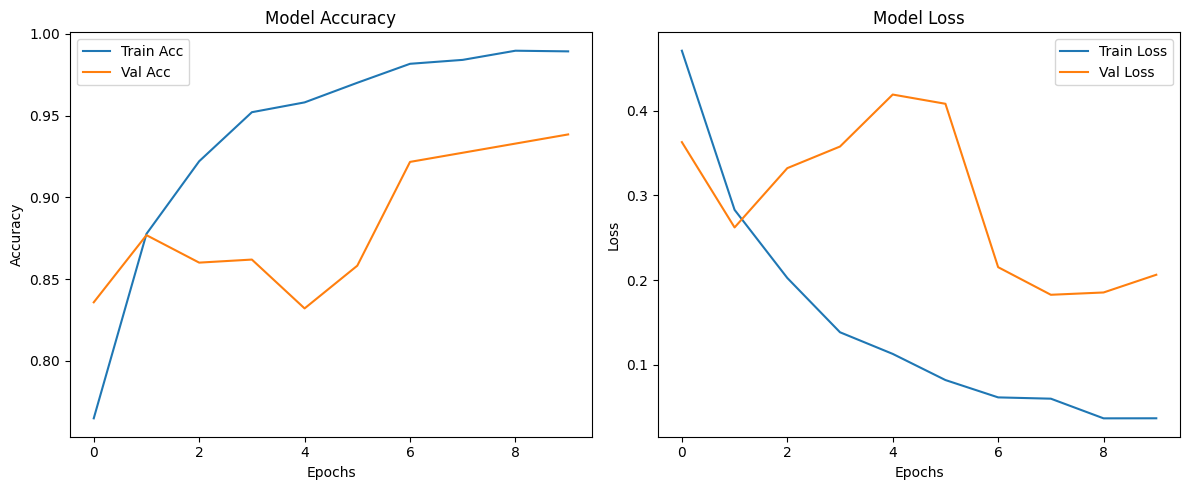

In [13]:
# === PLOT TRAINING CURVES ===
def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training(history_ft)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step

Classification Report:
               precision    recall  f1-score   support

   NO_THREAT       0.90      0.94      0.92       222
      THREAT       0.96      0.93      0.94       314

    accuracy                           0.93       536
   macro avg       0.93      0.93      0.93       536
weighted avg       0.93      0.93      0.93       536



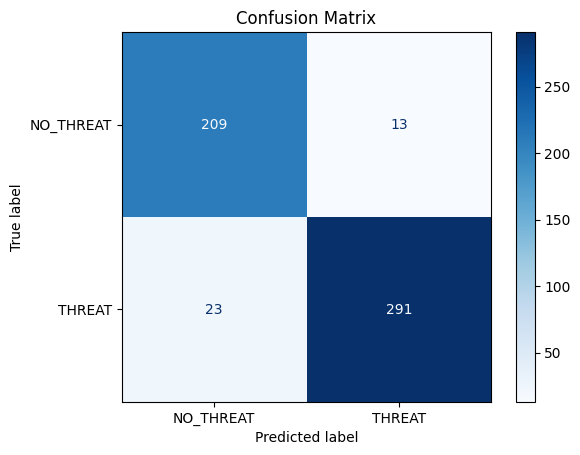

In [8]:
# === EVALUATE ON TEST ===
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_names))

cm = confusion_matrix(y_test, y_pred)

# Step 4: Display confusion matrix with sklearn's built-in tool
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

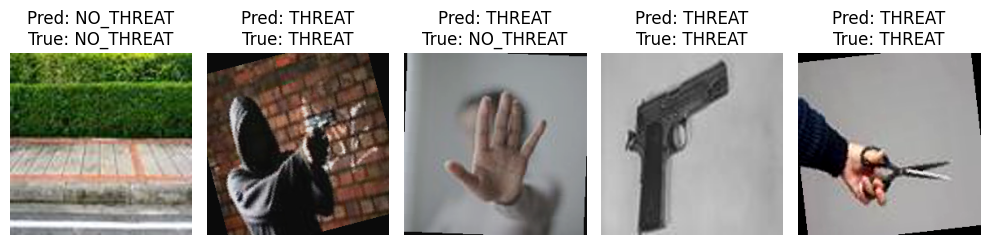

In [24]:
# === SHOW 5 RANDOM PREDICTIONS ===
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random.sample(range(len(X_test)), 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow((X_test[idx] + 1) / 2)  # inverse of preprocess_input
    plt.title(f"Pred: {label_names[y_pred[idx]]}\nTrue: {label_names[y_test[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()